In [75]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import vector as v
import numpy as np
import tensorflow as tf
#import keras
from energyflow.archs import PFN
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
#import tf_keras
from tf_keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
#mport tensorflow as tf
#from energyflow.archs import PFfrom tf_keras.callbacks import Adam
from tf_keras.losses import CategoricalCrossentropy,MeanSquaredError
gpu = tf.config.list_physical_devices('GPU')
print(gpu)
import numba

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [76]:
f_v=uproot.open("/home/shaikhar/DUST/CMSSW_12_5_5_patch1/data/powheg_vincia_inNANOAODGEN_vincia.root")
f_p=uproot.open("/home/shaikhar/DUST/CMSSW_12_5_5_patch1/src/powheg_pythia8_inNANOAODGEN.root")
eventsP=f_p["Events"]
print(eventsP.keys())

eventsV=f_v["Events"]

['run', 'luminosityBlock', 'event', 'bunchCrossing', 'HTXS_Higgs_pt', 'HTXS_Higgs_y', 'HTXS_stage1_1_cat_pTjet25GeV', 'HTXS_stage1_1_cat_pTjet30GeV', 'HTXS_stage1_1_fine_cat_pTjet25GeV', 'HTXS_stage1_1_fine_cat_pTjet30GeV', 'HTXS_stage1_2_cat_pTjet25GeV', 'HTXS_stage1_2_cat_pTjet30GeV', 'HTXS_stage1_2_fine_cat_pTjet25GeV', 'HTXS_stage1_2_fine_cat_pTjet30GeV', 'HTXS_stage_0', 'HTXS_stage_1_pTjet25', 'HTXS_stage_1_pTjet30', 'HTXS_njets25', 'HTXS_njets30', 'nGenJetAK8', 'GenJetAK8_eta', 'GenJetAK8_mass', 'GenJetAK8_phi', 'GenJetAK8_pt', 'nGenJet', 'GenJet_eta', 'GenJet_mass', 'GenJet_phi', 'GenJet_pt', 'nGenPart', 'GenPart_eta', 'GenPart_mass', 'GenPart_phi', 'GenPart_pt', 'GenPart_genPartIdxMother', 'GenPart_pdgId', 'GenPart_status', 'GenPart_statusFlags', 'Generator_binvar', 'Generator_scalePDF', 'Generator_weight', 'Generator_x1', 'Generator_x2', 'Generator_xpdf1', 'Generator_xpdf2', 'Generator_id1', 'Generator_id2', 'GenVtx_x', 'GenVtx_y', 'GenVtx_z', 'nGenVisTau', 'GenVisTau_eta', 'G

In [77]:
pt = eventsP["GenJet_pt"].array()
pdgId = eventsP["GenPart_pdgId"].array()


In [78]:

v.register_awkward()

def collect_particles_with_vector(events):
    pt      = events["GenPart_pt"].array()
    eta     = events["GenPart_eta"].array()
    phi     = events["GenPart_phi"].array()
    mass    = events["GenPart_mass"].array()
    pdgId   = events["GenPart_pdgId"].array()
    mother  = events["GenPart_genPartIdxMother"].array()

    # Lorentz vector 
    vec = ak.zip({
        "pt": pt,
        "eta": eta,
        "phi": phi,
        "mass": mass
    }, with_name="Momentum4D")  

    # Attach other info 
    particles = ak.zip({
        "vec": vec,               
        "pdgId": pdgId,
        "motherIdx": mother
    })

    return particles


In [79]:
particlesP = collect_particles_with_vector(eventsP)
particlesV = collect_particles_with_vector(eventsV)
print(ak.to_list(particlesP[0][0]))
print(particlesP[0])


{'vec': {'pt': 0.0, 'eta': 29256.0, 'phi': 0.0, 'mass': 0.9384765625}, 'pdgId': 2212, 'motherIdx': -1}
[{vec: {pt: 0, eta: 2.93e+04, ...}, pdgId: 2212, motherIdx: -1}, ..., {...}]


In [80]:
print(particlesP[0][3])

{vec: {pt: 0, eta: -2.3e+04, ...}, pdgId: 21, motherIdx: 8}


In [81]:
muons = particlesP[(abs(particlesP["pdgId"]) == 13) & (particlesP["vec"].pt > 20)]
print(muons)

[[], [], [], ..., [{vec: {pt: 57.7, ...}, pdgId: 13, motherIdx: 139}, ...], []]


In [82]:
@numba.jit(nopython=True)
def get_mother_pdgids_lastcopy(motheridxs, pdgids, offsets):
    # Find PDG ID of the ancestor particle with a different ID
    motherpdgids = np.zeros_like(pdgids)
    for i in range(len(offsets) - 1):
        offset = offsets[i]
        num_parts = offsets[i + 1] - offset
        for j in range(num_parts):
            pdgid = pdgids[offset + j]
            motheridx = motheridxs[offset + j]
            motheridx_old = j
            while 0 <= motheridx < motheridx_old:
                motherpdgid = pdgids[offset + motheridx]
                if motherpdgid != pdgid:
                    motherpdgids[offset + j] = motherpdgid
                    break
                motheridx_old = motheridx
                motheridx = motheridxs[offset + motheridx]
    return motherpdgids



In [83]:
flat_pdgid_P = ak.flatten(particlesP["pdgId"])
flat_motheridx_P = ak.flatten(particlesP["motherIdx"])

offsets_P = np.r_[0, np.cumsum(ak.num(particlesP))]

mother_pdgids_P = get_mother_pdgids_lastcopy(
    np.asarray(flat_motheridx_P),
    np.asarray(flat_pdgid_P),
    offsets_P
)

true_mother_pdgid_P = ak.unflatten(mother_pdgids_P, ak.num(particlesP))

particlesP["trueMotherId"] = true_mother_pdgid_P
print(mother_pdgids_P)

[   0    0    0 ... -311  111  111]


In [84]:
flat_pdgid_V = ak.flatten(particlesV["pdgId"])
flat_motheridx_V = ak.flatten(particlesV["motherIdx"])

offsets_V = np.r_[0, np.cumsum(ak.num(particlesV))]

mother_pdgids_V = get_mother_pdgids_lastcopy(
    np.asarray(flat_motheridx_V),
    np.asarray(flat_pdgid_V),
    offsets_V
)

true_mother_pdgid_V = ak.unflatten(mother_pdgids_V, ak.num(particlesV))

particlesV["trueMotherId"] = true_mother_pdgid_V
print(mother_pdgids_V)

[  0   0   0 ... 421 111 111]


In [85]:
#print(ak.to_list(particlesP[1][1]))
print(particlesP[particlesP["motherIdx"]]["pdgId"])
print(particlesP[particlesP["motherIdx"]]["trueMotherId"])

print(particlesV[particlesV["motherIdx"]]["pdgId"])
print(particlesV[particlesV["motherIdx"]]["trueMotherId"])


[[22, 22, 2, 21, 2, 2, 2, 2, ..., -3212, 221, 221, 213, 213, 111, 111], ...]
[[111, 111, 0, 0, 0, 0, 0, 0, ..., -4122, 431, 431, 431, 431, 213, 213], ...]
[[22, 22, 1, 21, 1, 1, 1, -6, ..., 111, -213, -213, 113, 113, 111, 111], ...]
[[111, 111, 0, 0, 0, 0, 0, 1, ..., 313, 333, 333, 331, 331, -213, -213], ...]


In [86]:
def get_daughters_from_W_from_top_eventwise(particles, mode="anti-leptonic", mom="W_plus", grand_mom="top"):
    if mode == "anti-leptonic":
        is_target = (particles["pdgId"] == -11) | (particles["pdgId"] == -13) | (particles["pdgId"] == -15) | \
                    (particles["pdgId"] == 12)   | (particles["pdgId"] == 14)   | (particles["pdgId"] == 16)
    elif mode == "leptonic":
        is_target = (particles["pdgId"] == 11) | (particles["pdgId"] == 13) | (particles["pdgId"] == 15) | \
                    (particles["pdgId"] == -12) | (particles["pdgId"] == -14) | (particles["pdgId"] == -16)
    elif mode == "quark":
        is_target = (abs(particles["pdgId"]) >= 1) & (abs(particles["pdgId"]) <= 4)
    else:
        raise ValueError("mode must be 'anti-leptonic', 'leptonic', or 'quark'")

    
    valid_mother = particles["motherIdx"] >= 0
    mothers = ak.where(
        valid_mother,
        particles[particles["motherIdx"]]["pdgId"],
        0
    )
    grandmothers = ak.where(
        valid_mother,
        particles[particles["motherIdx"]]["trueMotherId"],
        0
    )

    if mom == "W_plus" and grand_mom == "top":
        is_from_W = mothers == 24
        is_from_top = grandmothers == 6
    elif mom == "W_minus" and grand_mom == "anti-top":
        is_from_W = mothers == -24
        is_from_top = grandmothers == -6
    else:
        raise ValueError("Unsupported mom/grandmom combination")

    
    mask = is_target & is_from_W & is_from_top

    selected = particles[mask]
    selected = ak.where(ak.num(selected) == 2, selected, ak.Array([[]] * len(particles)))

    return selected


In [87]:
anti_leptons_from_top_P = get_daughters_from_W_from_top_eventwise(particlesP, mode="anti-leptonic",mom="W_plus",grand_mom="top")
anti_leptons_from_top_V = get_daughters_from_W_from_top_eventwise(particlesV, mode="anti-leptonic",mom="W_plus",grand_mom="top")
print(f"Total anti-leptons from W⁺ from top: {ak.sum(ak.num(anti_leptons_from_top_V))}")

print("Total pairs (events with anti-leptons and neutrinos from W⁺):", ak.sum(ak.num(anti_leptons_from_top_P) == 2))
print(len(anti_leptons_from_top_P))
print("Total pairs (events with anti-leptons and neutrinos from W⁺):", ak.sum(ak.num(anti_leptons_from_top_V) == 2))
print(len(anti_leptons_from_top_V))

Total anti-leptons from W⁺ from top: 9828
Total pairs (events with anti-leptons and neutrinos from W⁺): 4971
10000
Total pairs (events with anti-leptons and neutrinos from W⁺): 4914
10000


In [88]:
quarks_from_top_P = get_daughters_from_W_from_top_eventwise(particlesP, mode="quark",mom="W_plus",grand_mom="top")
quarks_from_top_V =get_daughters_from_W_from_top_eventwise(particlesV, mode="quark",mom="W_plus",grand_mom="top")


print(f"Total qq for pythia from W- from anti-top: {ak.sum(ak.num(quarks_from_top_P))}")
print(f"Total qq for vincia from W- from anti-top: {ak.sum(ak.num(quarks_from_top_V))}")

print("Total pairs (events with qq pairs  from W-):", ak.sum(ak.num(quarks_from_top_P) == 2))
print("Total pairs (events with qq pairs from W-):", ak.sum(ak.num(quarks_from_top_V) == 2))
print(len(quarks_from_top_P))
print(len(quarks_from_top_V))


Total qq for pythia from W- from anti-top: 10058
Total qq for vincia from W- from anti-top: 10020
Total pairs (events with qq pairs  from W-): 5029
Total pairs (events with qq pairs from W-): 5010
10000
10000


In [89]:
combined_pairs_P = ak.where(
    ak.num(anti_leptons_from_top_P) == 2,
    anti_leptons_from_top_P,
    quarks_from_top_P
)


combined_pairs_V = ak.where(
    ak.num(anti_leptons_from_top_V) == 2,
    anti_leptons_from_top_V,
    quarks_from_top_V
)


In [90]:
valid_W_mask_V = ak.num(combined_pairs_V) == 2
valid_W_mask_P = ak.num(combined_pairs_P) == 2

In [91]:
W_plus_P = (combined_pairs_P[valid_W_mask_P]["vec"][:, 0] +
            combined_pairs_P[valid_W_mask_P]["vec"][:, 1])
print(len(W_plus_P ))

W_plus_V = (combined_pairs_V[valid_W_mask_V]["vec"][:, 0] +
            combined_pairs_V[valid_W_mask_V]["vec"][:, 1])
print(len(W_plus_V ))

10000
9924


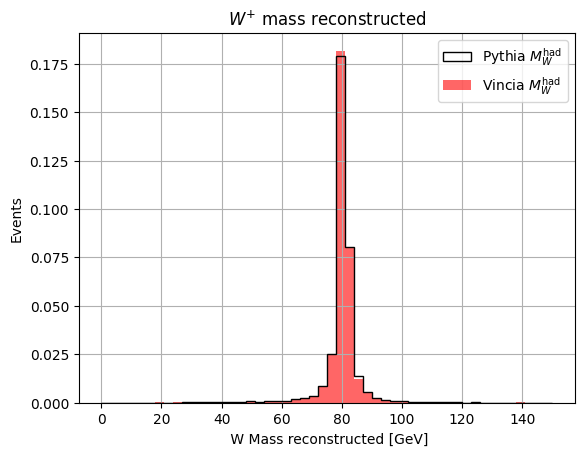

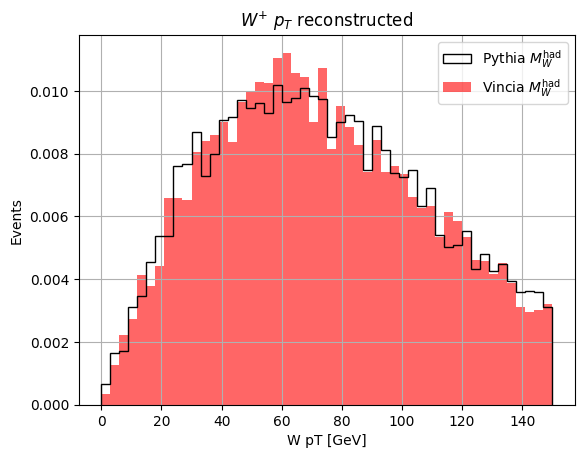

In [92]:
plt.hist(W_plus_P.mass, bins=50, range=(0, 150), histtype="step", color="black", label=r"Pythia $M_W^{\text{had}}$",density=True)
plt.hist(W_plus_V.mass, bins=50, range=(0, 150), alpha=0.6, color="red", label=r"Vincia $M_W^{\text{had}}$",density=True)
plt.xlabel(" W Mass reconstructed [GeV]")
plt.ylabel("Events")
plt.grid()
plt.legend()
plt.title(r"$W^{\text{+}}$ mass reconstructed")
plt.show()

plt.hist(W_plus_P.pt, bins=50, range=(0, 150), histtype="step", color="black", label=r"Pythia $M_W^{\text{had}}$",density=True)
plt.hist(W_plus_V.pt, bins=50, range=(0, 150), alpha=0.6, color="red", label=r"Vincia $M_W^{\text{had}}$",density=True)
plt.xlabel("W pT [GeV]")
plt.ylabel("Events")
plt.grid()
plt.legend()
plt.title(r"$W^{\text{+}}$ $p_T$ reconstructed")
plt.show()


In [93]:
#b-quarks selection 


is_b_quark_P = particlesP["pdgId"] == 5
valid_mother_P = particlesP["motherIdx"] >= 0
mothers_P = ak.where(
    valid_mother_P,
    particlesP[particlesP["motherIdx"]]["pdgId"],       #Pythia
    0
)
is_from_top_P = mothers_P == 6
is_b_from_top_P = is_b_quark_P & is_from_top_P
b_quarks_per_event_P = particlesP[is_b_from_top_P]




is_b_quark_V = particlesV["pdgId"] == 5
valid_mother_V = particlesV["motherIdx"] >= 0
mothers_V = ak.where(
    valid_mother_V,                                        #Vincia 
    particlesV[particlesV["motherIdx"]]["pdgId"],
    0
)
is_from_top_V = mothers_V == 6
is_b_from_top_V = is_b_quark_V & is_from_top_V
b_quarks_per_event_V = particlesV[is_b_from_top_V]
print(len(b_quarks_per_event_V))

10000


In [94]:
valid_W_mask_V = ak.num(combined_pairs_V) == 2

W_plus_P = combined_pairs_P["vec"][:, 0] + combined_pairs_P["vec"][:, 1]
print(len(W_plus_P))

W_plus_V = (combined_pairs_V[valid_W_mask_V]["vec"][:, 0] +
            combined_pairs_V[valid_W_mask_V]["vec"][:, 1])
print(len(W_plus_V ))

10000
9924


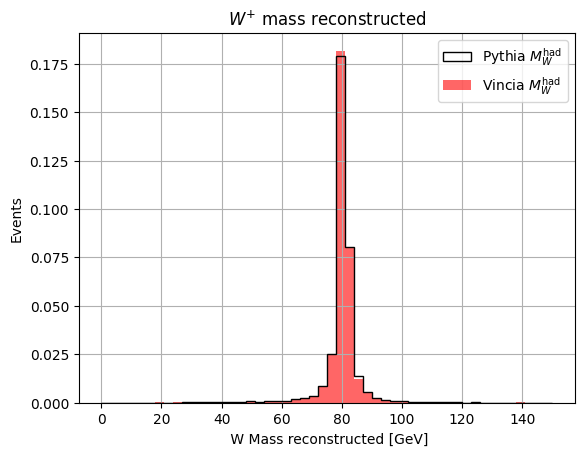

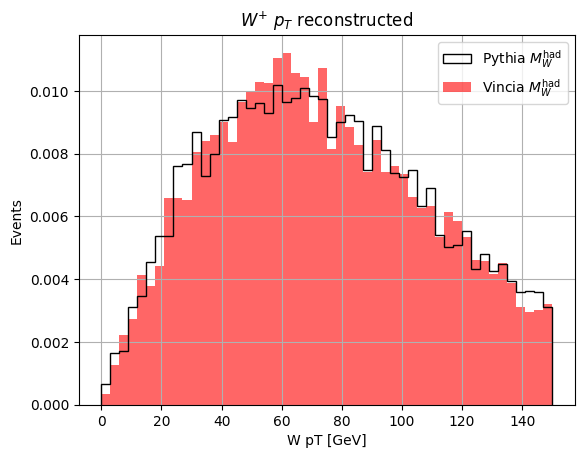

In [95]:
plt.hist(W_plus_P.mass, bins=50, range=(0, 150), histtype="step", color="black", label=r"Pythia $M_W^{\text{had}}$",density=True)
plt.hist(W_plus_V.mass, bins=50, range=(0, 150), alpha=0.6, color="red", label=r"Vincia $M_W^{\text{had}}$",density=True)
plt.xlabel(" W Mass reconstructed [GeV]")
plt.ylabel("Events")
plt.grid()
plt.legend()
plt.title(r"$W^{\text{+}}$ mass reconstructed")
plt.show()

plt.hist(W_plus_P.pt, bins=50, range=(0, 150), histtype="step", color="black", label=r"Pythia $M_W^{\text{had}}$",density=True)
plt.hist(W_plus_V.pt, bins=50, range=(0, 150), alpha=0.6, color="red", label=r"Vincia $M_W^{\text{had}}$",density=True)
plt.xlabel("W pT [GeV]")
plt.ylabel("Events")
plt.grid()
plt.legend()
plt.title(r"$W^{\text{+}}$ $p_T$ reconstructed")
plt.show()


In [96]:
top_P=W_plus_P+b_quarks_per_event_P["vec"]

In [97]:
valid_W = ak.num(combined_pairs_V) == 2
valid_b = ak.num(b_quarks_per_event_V) == 1
valid_events = valid_W & valid_b  # shape: (10000,)

In [98]:
W_plus_V = (combined_pairs_V[valid_events]["vec"][:, 0] +
            combined_pairs_V[valid_events]["vec"][:, 1])

b_vecs_V = b_quarks_per_event_V[valid_events]["vec"][:, 0]


In [99]:
top_V = W_plus_V + b_vecs_V
print(len(top_V))

9923


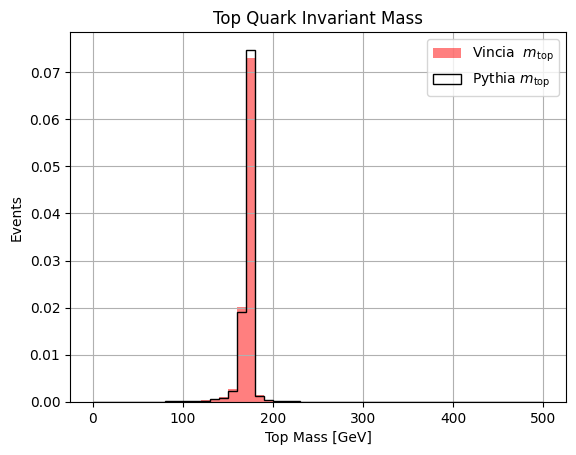

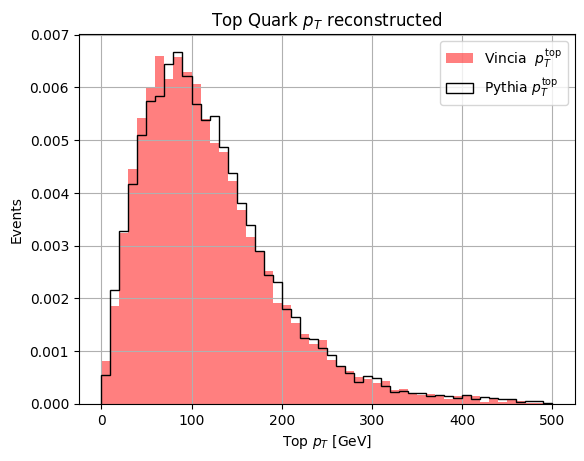

In [100]:
plt.hist(top_V.mass, bins=50, range=(0, 500), alpha=0.5, color="red", label=r"Vincia  $m_\mathrm{top}$",density=True)
plt.hist(top_P.mass,bins=50,range=(0,500),histtype="step",color="black",label=r"Pythia $m_\mathrm{top}$",density=True)        
plt.xlabel("Top Mass [GeV]")
plt.ylabel("Events")
plt.title("Top Quark Invariant Mass")
plt.legend()
plt.grid(True)
plt.show()

plt.hist(top_V.pt, bins=50, range=(0, 500), alpha=0.5, color="red", label=r"Vincia  $p_T^\mathrm{top}$",density=True)
plt.hist(top_P.pt,bins=50,range=(0,500),histtype="step",color="black",label=r"Pythia $p_T^\mathrm{top}$",density=True)
plt.xlabel("Top $p_T$ [GeV]")
plt.ylabel("Events")
plt.title("Top Quark $p_T$ reconstructed")
plt.legend()
plt.grid(True)
plt.show()


In [101]:
#Anti-top

leptons_from_anti_top_P = get_daughters_from_W_from_top_eventwise(particlesP, mode="leptonic",mom="W_minus",grand_mom="anti-top")
leptons_from_anti_top_V = get_daughters_from_W_from_top_eventwise(particlesV, mode="leptonic",mom="W_minus",grand_mom="anti-top")
print(f"Total leptons for pythia from W- from anti-top: {ak.sum(ak.num(leptons_from_anti_top_P))}")
print(f"Total leptons for vincia from W- from anti-top: {ak.sum(ak.num(leptons_from_anti_top_V))}")

print("Total pairs (events with anti-leptons and neutrinos from W-):", ak.sum(ak.num(leptons_from_anti_top_P) == 2))
print("Total pairs (events with anti-leptons and neutrinos from W-):", ak.sum(ak.num(leptons_from_anti_top_V) == 2))
print(len(leptons_from_anti_top_P))
print(len(leptons_from_anti_top_V))


Total leptons for pythia from W- from anti-top: 10058
Total leptons for vincia from W- from anti-top: 10056
Total pairs (events with anti-leptons and neutrinos from W-): 5029
Total pairs (events with anti-leptons and neutrinos from W-): 5028
10000
10000


In [102]:
quarks_from_anti_top_P = get_daughters_from_W_from_top_eventwise(particlesP, mode="quark",mom="W_minus",grand_mom="anti-top")
quarks_from_anti_top_V =get_daughters_from_W_from_top_eventwise(particlesV, mode="quark",mom="W_minus",grand_mom="anti-top")

print(f"Total qq for pythia from W- from anti-top: {ak.sum(ak.num(quarks_from_anti_top_P))}")
print(f"Total qq for vincia from W- from anti-top: {ak.sum(ak.num(quarks_from_anti_top_V))}")

print("Total pairs (events with qq pairs  from W-):", ak.sum(ak.num(quarks_from_anti_top_P) == 2))
print("Total pairs (events with qq pairs from W-):", ak.sum(ak.num(quarks_from_anti_top_V) == 2))
print(len(quarks_from_anti_top_P))
print(len(quarks_from_anti_top_V))


Total qq for pythia from W- from anti-top: 9942
Total qq for vincia from W- from anti-top: 9790
Total pairs (events with qq pairs  from W-): 4971
Total pairs (events with qq pairs from W-): 4895
10000
10000


In [103]:
combined_pairs_P2 = ak.where(
    ak.num(leptons_from_anti_top_P) == 2,
    leptons_from_anti_top_P,
    quarks_from_anti_top_P
)


combined_pairs_V2 = ak.where(
    ak.num(leptons_from_anti_top_V) == 2,
    leptons_from_anti_top_V,
    quarks_from_anti_top_V
)


In [104]:
valid_W_mask_V2 = ak.num(combined_pairs_V2) == 2


In [105]:
W_minus_P = combined_pairs_P2["vec"][:, 0] + combined_pairs_P2["vec"][:, 1]
print(len(W_minus_P))

W_minus_V = (combined_pairs_V2[valid_W_mask_V2]["vec"][:, 0] +
            combined_pairs_V2[valid_W_mask_V2]["vec"][:, 1])
print(len(W_minus_V ))

10000
9923


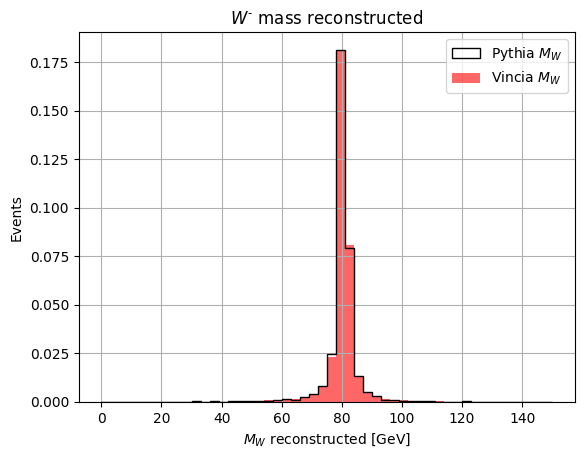

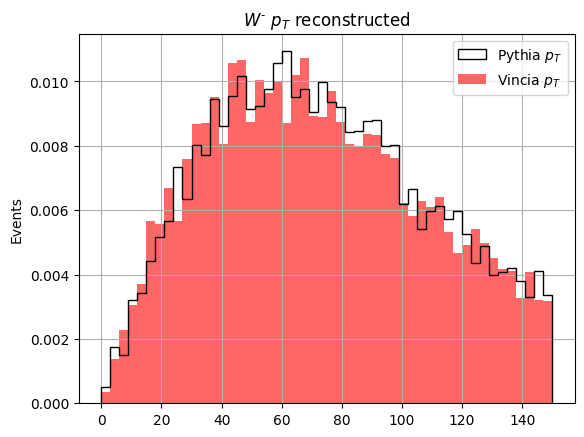

In [106]:
plt.hist(W_minus_P.mass, bins=50, range=(0, 150), histtype="step", color="black", label=r"Pythia $M_W$",density=True)
plt.hist(W_minus_V.mass, bins=50, range=(0, 150), alpha=0.6, color="red", label=r"Vincia $M_W$",density=True)
plt.xlabel(r"$M_W$ reconstructed [GeV]")
plt.ylabel("Events")
plt.grid()
plt.legend()
plt.title(r"$W^{\text{-}}$ mass reconstructed")
plt.show()

plt.hist(W_minus_P.pt, bins=50, range=(0, 150), histtype="step", color="black", label=r"Pythia $p_T$",density=True)
plt.hist(W_minus_V.pt, bins=50, range=(0, 150), alpha=0.6, color="red", label=r"Vincia $p_T$",density=True)
plt.ylabel("Events")
plt.grid()
plt.legend()
plt.title(r"$W^{\text{-}}$ $p_T$ reconstructed")
plt.show()


In [107]:
#Anti-b quarks selection 


is_b_bar_quark_P = particlesP["pdgId"] == -5
valid_mother_P2 = particlesP["motherIdx"] >= 0
mothers_P2 = ak.where(
    valid_mother_P2,
    particlesP[particlesP["motherIdx"]]["pdgId"],       #Pythia
    0
)
is_from_anti_top_P = mothers_P2 == -6
is_b_bar_from_anti_top_P = is_b_bar_quark_P & is_from_anti_top_P
b_bar_quarks_per_event_P = particlesP[is_b_bar_from_anti_top_P]




is_b_bar_quark_V = particlesV["pdgId"] == -5
valid_mother_V2 = particlesV["motherIdx"] >= 0
mothers_V2 = ak.where(
    valid_mother_V2,
    particlesV[particlesV["motherIdx"]]["pdgId"],       #Vincia
    0
)
is_from_anti_top_V = mothers_V2 == -6
is_b_bar_from_anti_top_V = is_b_bar_quark_V & is_from_anti_top_V
b_bar_quarks_per_event_V = particlesV[is_b_bar_from_anti_top_V]

print(ak.sum(ak.num(b_bar_quarks_per_event_V)))

10003


In [108]:
anti_top_P=W_minus_P+b_bar_quarks_per_event_P["vec"]
#top_V=W_plus_V+b_quarks_per_event_V["vec"]

In [109]:
valid_W2 = ak.num(combined_pairs_V2) == 2
valid_b_bar = ak.num(b_bar_quarks_per_event_V) == 1
valid_events2 = valid_W2 & valid_b_bar  # shape: (10000,)


In [110]:
W_minus_V = (combined_pairs_V2[valid_events2]["vec"][:, 0] +
            combined_pairs_V2[valid_events2]["vec"][:, 1])

b_bar_vecs_V = b_bar_quarks_per_event_V[valid_events2]["vec"][:, 0]
print(len(b_bar_vecs_V))


9920


In [111]:
anti_top_V = W_minus_V + b_bar_vecs_V
print(len(anti_top_V))


9920


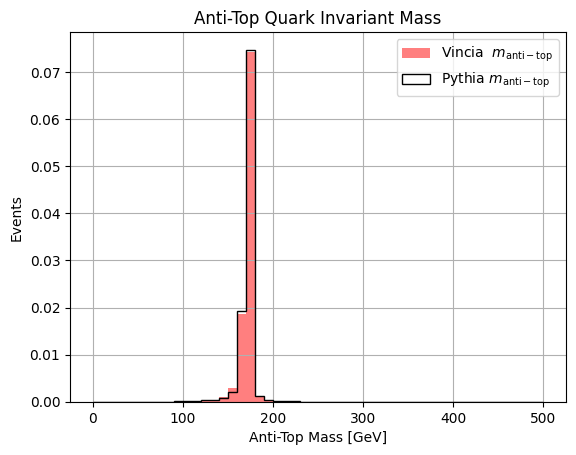

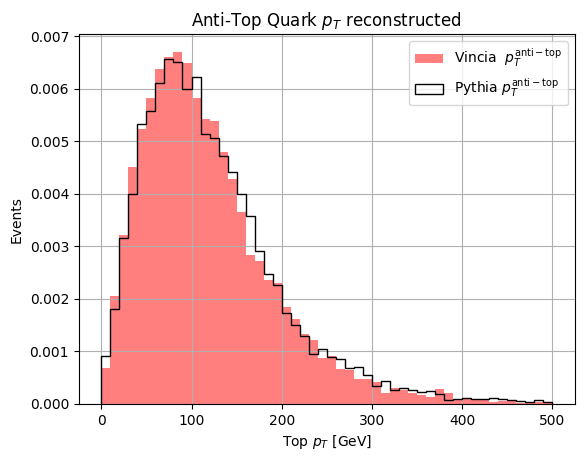

In [112]:
plt.hist(anti_top_V.mass, bins=50, range=(0, 500), alpha=0.5, color="red", label=r"Vincia  $m_\mathrm{anti-top}$",density=True)
plt.hist(anti_top_P.mass,bins=50,range=(0,500),histtype="step",color="black",label=r"Pythia $m_\mathrm{anti-top}$",density=True)        
plt.xlabel("Anti-Top Mass [GeV]")
plt.ylabel("Events")
plt.title("Anti-Top Quark Invariant Mass")
plt.legend()
plt.grid(True)
plt.show()

plt.hist(anti_top_V.pt, bins=50, range=(0, 500), alpha=0.5, color="red", label=r"Vincia  $p_T^\mathrm{anti-top}$",density=True)
plt.hist(anti_top_P.pt,bins=50,range=(0,500),histtype="step",color="black",label=r"Pythia $p_T^\mathrm{anti-top}$",density=True)
plt.xlabel("Top $p_T$ [GeV]")
plt.ylabel("Events")
plt.title("Anti-Top Quark $p_T$ reconstructed")
plt.legend()
plt.grid(True)
plt.show()


In [113]:
valid_top_mask = (ak.num(combined_pairs_V) == 2) & (ak.num(b_quarks_per_event_V) == 1)
valid_antitop_mask = (ak.num(combined_pairs_V2) == 2) & (ak.num(b_bar_quarks_per_event_V) == 1)
valid_ttbar_mask = valid_top_mask & valid_antitop_mask


In [114]:
W_top_vecs = combined_pairs_V[valid_ttbar_mask]["vec"][:, 0] + combined_pairs_V[valid_ttbar_mask]["vec"][:, 1]
b_top_vecs = b_quarks_per_event_V[valid_ttbar_mask]["vec"][:, 0]
top_vecs = W_top_vecs + b_top_vecs

W_antitop_vecs = combined_pairs_V2[valid_ttbar_mask]["vec"][:, 0] + combined_pairs_V2[valid_ttbar_mask]["vec"][:, 1]
bbar_vecs = b_bar_quarks_per_event_V[valid_ttbar_mask]["vec"][:, 0]
antitop_vecs = W_antitop_vecs + bbar_vecs
print(len(b_top_vecs))

9845


In [115]:
ttbar_vecs_V = top_vecs + antitop_vecs
print(len(antitop_vecs))

9845


In [116]:
ttbar_vecs_P=top_P+anti_top_P
print(len(ttbar_vecs_P))

10000


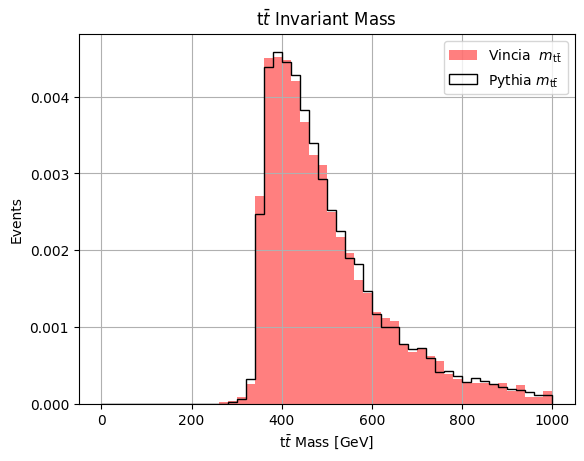

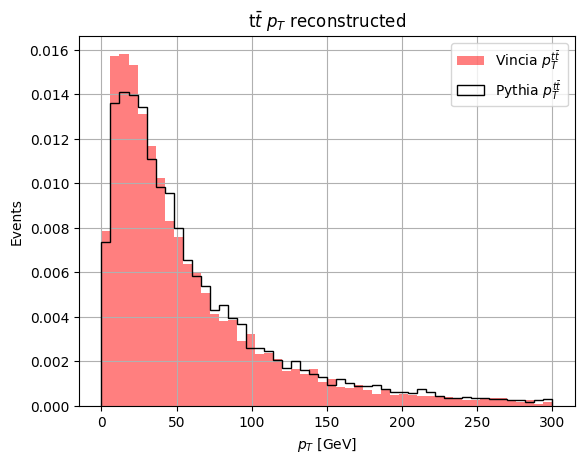

In [117]:
plt.hist(ttbar_vecs_V.mass, bins=50, range=(0, 1000), alpha=0.5, color="red", label=r"Vincia  $m_\mathrm{t{\bar t}}$",density=True)
plt.hist(ttbar_vecs_P.mass,bins=50,range=(0,1000),histtype="step",color="black",label=r"Pythia $m_\mathrm{t{\bar t}}$",density=True)        
plt.xlabel(r"t${\bar t}$ Mass [GeV]")
plt.ylabel("Events")
plt.title(r"t${\bar t}$ Invariant Mass")
plt.legend()
plt.grid(True)
plt.show()

plt.hist(ttbar_vecs_V.pt, bins=50, range=(0, 300), alpha=0.5, color="red", label=r"Vincia $p_T^{t\bar{t}}$",density=True)
plt.hist(ttbar_vecs_P.pt,bins=50,range=(0,300),histtype="step",color="black",label=r"Pythia $p_T^{t\bar{t}}$",density=True)
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.title(r"t${\bar t}$ $p_T$ reconstructed")
plt.legend()
plt.grid(True)
plt.show()


In [118]:
print(ak.type(ttbar_vecs_V))
print(ttbar_vecs_V[0])

9845 * Momentum4D[rho: float32, phi: float32, eta: float32, tau: float32]
{rho: 155, phi: -0.137, eta: 1.87, tau: 584}


In [43]:
import awkward as ak
import numpy as np

# Use your Vincia vector source
ttbar_vecs = ttbar_vecs_V
label_value = 1  # Vincia label

# Convert to NumPy arrays
rho  = ak.to_numpy(ttbar_vecs.rho).astype(np.float32)
phi  = ak.to_numpy(ttbar_vecs.phi).astype(np.float32)
eta  = ak.to_numpy(ttbar_vecs.eta).astype(np.float32)
tau  = ak.to_numpy(ttbar_vecs.tau).astype(np.float32)
mass = ak.to_numpy(ttbar_vecs.mass).astype(np.float32)
pt   = ak.to_numpy(ttbar_vecs.pt).astype(np.float32)

# Reshape to structured array: (n_events, n_vectors, 6)
features_array = np.stack([rho, phi, eta, tau, mass, pt], axis=-1)

# Labels: (n_events,)
labels = np.full(features_array.shape[0], label_value, dtype=np.int8)

# Save the new structured Vincia file
np.savez("ttbar_vincia.npz", features=features_array, label=labels)

print("Re-saved structured Vincia file:", features_array.shape)


✅ Re-saved structured Vincia file: (9845, 6)


In [44]:
dataP=np.load("ttbar_pythia.npz")
dataV=np.load("ttbar_vincia.npz")
print(dataP)
print(dataV)

#features:rho, phi, eta, tau, mass, pt

NpzFile 'ttbar_pythia.npz' with keys: features, label
NpzFile 'ttbar_vincia.npz' with keys: features, label


In [53]:
dataP = np.load("ttbar_pythia.npz")
X_P = dataP["features"]  # shape = (n_events, n_vectors, 6)
Y_P = dataP["label"]     # shape = (n_events,)
print(X_P[0])


dataV = np.load("ttbar_vincia.npz")
X_V = dataV["features"]  # shape = (n_events, n_vectors, 6)
Y_V = dataV["label"] 

[[117.97729    -2.0987055   1.4871764 584.1042    584.1042    117.97729  ]]


In [59]:


print(X_P.shape,X_V.shape)

(60000, 1) (59070, 1)


In [117]:
print(type(X_P), type(X_V))
print(repr(X_P[:5]))
print(repr(X_V[:5]))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
array([[117.97729 ],
       [126.70173 ],
       [ 15.925835],
       [ 48.64923 ],
       [ 51.120296]], dtype=float32)
array([155.04305 ,  11.808092,  47.792202,  41.151203,   7.137766],
      dtype=float32)


In [119]:
print(ttbar_vecs_V[0])

{rho: 155, phi: -0.137, eta: 1.87, tau: 584}


In [120]:
print(W_minus_P,W_plus_P,top_P,anti_top_P,leptons_from_anti_top_P["vec"],anti_leptons_from_top_P["vec"],quarks_from_top_P["vec"],quarks_from_anti_top_P["vec"])

[{rho: 62, phi: -0.996, eta: 0.894, tau: 77.1}, ..., {rho: 65.4, phi: ..., ...}] [{rho: 162, phi: 2.92, eta: -0.302, tau: 79.4}, ..., {rho: 78.4, phi: ..., ...}] [[{rho: 155, phi: 2.6, eta: -0.425, tau: 172}], ..., [{rho: 74.5, ...}]] [[{rho: 196, phi: -1.19, eta: 1.25, tau: 159}], ..., [{rho: 56.7, ...}]] [[], [], [], ..., [], [{pt: 57.7, eta: 1.03, phi: 2.11, mass: 0}, {...}], []] [[{pt: 44.1, eta: 0.474, phi: 2.84, mass: 0}, {pt: 118, ...}], ..., [...]] [[], [], [], ..., [{pt: 19.9, eta: -0.434, phi: 0.0555, mass: 0}, {...}], []] [[{pt: 65.3, eta: 0.835, phi: -0.558, mass: 0}, {pt: 27.8, ...}], ..., [...]]


In [121]:
print(ttbar_vecs_P)

[[{rho: 118, phi: -2.1, eta: 1.49, tau: 584}], [{...}], ..., [{rho: 18.1, ...}]]


In [126]:
ttbar_vecs_flat_P=ak.flatten(ttbar_vecs_P)
top_flat_P=ak.flatten(top_P)
anti_top_flat_P=ak.flatten(anti_top_P)
anti_leptons_from_top_flat_P=ak.flatten(anti_leptons_from_top_P["vec"])

In [172]:
print(anti_leptons_from_top_P["vec"])

[[{pt: 44.1, eta: 0.474, phi: 2.84, mass: 0}, {pt: 118, ...}], ..., [...]]


In [181]:
def vector_or_pad(entry):
    return {
        'pt': entry['pt'] if entry is not None else 0.0,
        'eta': entry['eta'] if entry is not None else 0.0,
        'phi': entry['phi'] if entry is not None else 0.0,
        'mass': entry['mass'] if entry is not None else 0.0
    }




In [189]:
#cleaned = [vector_or_pad(vec1) for vec1 in leptons_from_anti_top_flat2_P]
#print(cleaned)

In [195]:
def extract_first_two_vectors(vec_array):
    """
    Extracts and pads the first and second vectors from each sublist in an awkward array.
    
    Parameters:
        vec_array (list or awkward.Array): A list of sublists, each with dict-like vectors
    
    Returns:
        tuple of two lists of dicts: (first_vector_padded, second_vector_padded)
    """
    vecs = ak.Array(vec_array)

    # leptons
    first = ak.firsts(vecs)
    first_padded = [vector_or_pad(v) for v in first]

    # neutrinos
    padded = ak.pad_none(vecs, 2)
    second = padded[:, 1]
    second_padded = [vector_or_pad(v) for v in second]

    return first_padded, second_padded

In [196]:
#extracing leptons and neutrinos vectors 

anti_leptons_from_top_flat2_pad_P, neutrinos_from_top_flat2_pad_P = extract_first_two_vectors(
    anti_leptons_from_top_P["vec"]
)

leptons_from_anti_top_flat2_pad_P, anti_neutrinos_from_anti_top_flat2_pad_P = extract_first_two_vectors(
    leptons_from_anti_top_P["vec"]
)


In [237]:
print(len(anti_leptons_from_top_flat2_pad_P))

10000


In [194]:
print(quarks_from_top_P["vec"])

[[], [], [], ..., [{pt: 19.9, eta: -0.434, phi: 0.0555, mass: 0}, {...}], []]


In [203]:
q_from_top_flat2_pad_P, q_bar_from_top_flat2_pad_P = extract_first_two_vectors(
    quarks_from_top_P["vec"]
)

q_from_anti_top_flat2_pad_P, q_bar_from_anti_top_flat2_pad_P = extract_first_two_vectors(
    quarks_from_anti_top_P["vec"]
)


In [235]:
print(len(q_from_anti_top_flat2_pad_P))

10000


In [217]:
print(top_flat_P)

[{rho: 155, phi: 2.6, eta: -0.425, tau: 172}, ..., {rho: 74.5, phi: -1.32, ...}]


In [218]:
def vector_rho_to_pt_eta_phi_mass(vec_array):
    """
    Converts awkward array with (rho, eta, phi, tau) to (pt, eta, phi, mass)
    """
    
    vecs = ak.Array(vec_array)

    
    pt   = vecs.pt      
    eta  = vecs.eta
    phi  = vecs.phi
    mass = vecs.mass    

    
    return [{'pt': float(p), 'eta': float(e), 'phi': float(ph), 'mass': float(m)}
            for p, e, ph, m in zip(pt, eta, phi, mass)]

In [243]:
top_clean_P = vector_rho_to_pt_eta_phi_mass(top_flat_P)
anti_top_clean_P= vector_rho_to_pt_eta_phi_mass(anti_top_flat_P)
ttbar_vecs_clean_P=vector_rho_to_pt_eta_phi_mass(ttbar_vecs_flat_P)

In [239]:
print(len(anti_top_clean_P))

10000


In [233]:
b_quarks_per_event_flat_P=ak.flatten(b_quarks_per_event_P["vec"])
b_bar_quarks_per_event_flat_P=ak.flatten(b_bar_quarks_per_event_P["vec"])
print(b_bar_quarks_per_event_flat_P)
print(len(b_quarks_per_event_flat_P))


[{pt: 136, eta: 1.38, phi: -1.28, mass: 0}, ..., {pt: 61.7, eta: 1.55, ...}]
10000


In [242]:
print((ttbar_vecs_flat_P))

[{rho: 118, phi: -2.1, eta: 1.49, tau: 584}, ..., {rho: 18.1, phi: -1.5, ...}]


In [ ]:
"""
Now make .npz file including these particles leptons,neutrinos,anti-leptons,anti-neutrinos,W+,W-,b,b-bar,top,anti-top and finally tt-bar system.
This is for Pythia 
"""

In [240]:
def dicts_to_numpy(particles):
    """
    Converts list of dicts with keys 'pt', 'eta', 'phi', 'mass' to numpy array (N, 4)
    """
    return np.array([[p['pt'], p['eta'], p['phi'], p['mass']] for p in particles], dtype=np.float32)


In [246]:
def dicts_to_numpy(particles):
    return np.array([[p['pt'], p['eta'], p['phi'], p['mass']] for p in particles], dtype=np.float32)


particle_lists = {
    "b_quark": b_quarks_per_event_flat_P,
    "b_bar_quark": b_bar_quarks_per_event_flat_P,
    "lep_top": anti_leptons_from_top_flat2_pad_P,
    "nu_top": neutrinos_from_top_flat2_pad_P,
    "lep_atop": leptons_from_anti_top_flat2_pad_P,
    "nu_atop": anti_neutrinos_from_anti_top_flat2_pad_P,
    "q_top": q_from_top_flat2_pad_P,
    "q_bar_top": q_bar_from_top_flat2_pad_P,
    "q_atop": q_from_anti_top_flat2_pad_P,
    "q_bar_atop": q_bar_from_anti_top_flat2_pad_P,
}

# Convert to (N_events, 4)
arrays = {name: dicts_to_numpy(data) for name, data in particle_lists.items()}

num_events = len(next(iter(arrays.values())))
assert all(len(arr) == num_events for arr in arrays.values()), "Mismatch in event counts!"

# Stack into shape (N_events, N_particles, 4)
X = np.stack([arrays[name] for name in particle_lists], axis=1)

# Save to npz
np.savez("ttbar_pythia_PFN_input.npz", X=X)

print("Saved as: ttbar_event_PFN_input.npz")
print("Shape:", X.shape)


Saved as: ttbar_event_PFN_input.npz
Shape: (10000, 10, 4)


In [252]:
data = np.load("ttbar_pythia_PFN_input.npz")
print(data.files)   

X=data["X"]
print(X.shape)

['X']
(10000, 10, 4)
